In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as pl
import scipy.ndimage as nd
import time

%matplotlib inline
%load_ext line_profiler

Topics in Python optimization
================

> We should forget about small efficiencies, say about 97% of the time: **premature optimization is the root of all evil**. Yet we should not pass up our opportunities in that critical 3% -- Donald Knuth

When to optimize
-------------------

Step one in optimizing is deciding whether it is actually necessary.  The point that Knuth raises is that people spend a lot of time thinking of and developing optimizations for code that may in fact not matter.  The question "does it matter?" is actually quite complex.  Consider:

* How long does the code take overall? -- if a single run takes 1ms, why bother?
* How many times does it get executed? -- if that 1ms code is run 10^7 times (3 days), now we're talking
* How much improvement can you get? -- if you can only get 10% improvement, then almost certainly not worth the 7 hr gained
* How long would it take you to fix? -- if it takes you longer than 3 days, then you could have just run the code


Assuming that your answers to 1 and 2 lead you to optimize, let's visit questions 3 and 4.

Where to optimize
--------------------

Often, there is only a section of a program that needs to be addressed, usually the inner loop that is computationally intensive.  It is important to remove your prejudices though.  To study which parts of your program are slow and how much you can gain, *profile*.

### Profiling

Python includes many different options for finding the speed of different code sections.

* %timeit -- quick way to look the speed of a single function call
* %prun -- distribution of time broken down by function (aggregates are useful)
* %lprun -- line profiling

In [2]:
def create_noisy_sin(N=1000):
    x = np.linspace(0, 12*np.pi, N)
    y = np.sin(x) 
    d = y + (2*np.random.rand(*x.shape)-1)
    return x, d

x, y = create_noisy_sin(1000)

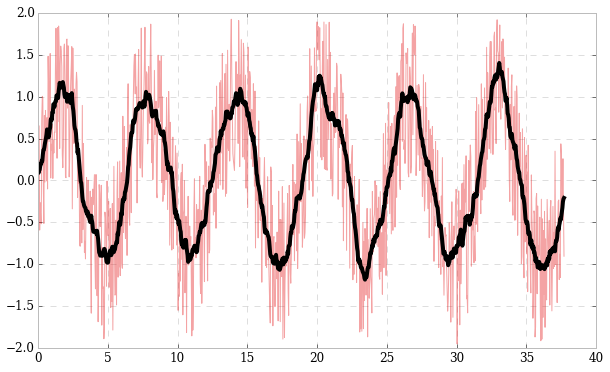

In [6]:
def boxcar1(a, size):
    length = a.shape[0]
    out = np.zeros_like(a)

    # for each element in the list
    for i in xrange(length):
        
        # add the `size' adjacent elements before and after this element
        for j in xrange(max(0,i-size/2), min(length,i+size/2+1)):
            out[i] += a[j]

    return out/size

x, y = create_noisy_sin(1000)
fig = pl.figure(figsize=(10,6))
pl.plot(x, y, lw=1, alpha=0.4)
pl.plot(x, boxcar1(y,20), lw=4, c='k')
_ = pl.ylim(-2,2)

In [7]:
x, y = create_noisy_sin(10000)
%timeit boxcar1(y, 100)

1 loops, best of 3: 266 ms per loop


Order of magnitude
---------------------

450 ms is not bad, the plot refresh time.  But is it fast enough? Let's estimate how long this function should really take.  For an array of length 10000 and a filter of size 100, we have approximately 10^4 multiply-adds.  For each 10^4 we have to visit 100 other elements and add them together.  An i7 procressor at 3GHz can do ~ 20 GFlops per core -- the code should run in:

50 microsecond!

In [97]:
%prun boxcar1(y, 100)

In [98]:
%lprun -f boxcar1 boxcar1(y, 100)

Converting to numpy
===========

So much time is spent on xrange in the inner loop, let's switch to numpy!

In [8]:
def boxcar2(a, size):
    out = np.zeros_like(a)
    for i in xrange(size):
        out[i:-(size-i)] += a[size/2:-size/2]
    return out/size

In [9]:
%timeit boxcar2(y, 100)

1000 loops, best of 3: 543 µs per loop


In [108]:
%lprun -f boxcar2 boxcar2(y, 100)

C/C++ solutions
=========

In Python, we often have to turn to external libraries such as numpy to achieve the ultimate speed.  If the solution if already written for us, we can blame someone else for bugs and for the algorithm.

In [10]:
def boxcar3(a, size):
    return nd.filters.uniform_filter1d(a, size, mode='constant', cval=0)

%timeit boxcar1(y, 100)
%timeit boxcar2(y, 100)
%timeit boxcar3(y, 100)

1 loops, best of 3: 264 ms per loop
1000 loops, best of 3: 544 µs per loop
10000 loops, best of 3: 60.4 µs per loop


# Python libraries

* numpy -- linear algebra, special functions, numeric utilities
* scipy -- extending numpy for more specialized cases
* numexpr -- improve caching, level 1 BLAS routines (multi-core)
* numba -- JIT compiler for numpy
* pyfftw -- fastest fourier transform in the west

In [14]:
import numexpr as ne

a = np.random.rand(1000000)

%timeit a+a
%timeit ne.evaluate('a+a')

print '='*50

%timeit a**8 + np.sin(1.0/a)
%timeit ne.evaluate('a**8 + sin(1.0/a)')

1000 loops, best of 3: 1.23 ms per loop
1000 loops, best of 3: 1.24 ms per loop
10 loops, best of 3: 96.5 ms per loop
100 loops, best of 3: 6.2 ms per loop


In [16]:
import math
from numba import jit

@jit(nopython=True)
def weird_func(a_in, a_out, N):
    for i in xrange(N):
        a_out[i] = a_in[i]**8 + math.sin(1.0/a_in[i])
    return a_out

a = np.random.rand(1000000)
b = np.zeros_like(a)

%timeit weird_func(a,b,len(a))

10 loops, best of 3: 85.8 ms per loop


In [22]:
import pyfftw
from pyfftw.builders import fft2

a = np.random.rand(512,512)
pfft2 = fft2(a, overwrite_input=False, planner_effort='FFTW_MEASURE', threads=4)

%timeit np.fft.fft2(a)
%timeit pfft2.execute()

100 loops, best of 3: 9.98 ms per loop
100 loops, best of 3: 2.79 ms per loop


Algorithms
======

So far we have been missing the biggest piece of optimization: algorithms.  Given a method for solving a problem, those previous tricks help a lot.  However, changing your outlook on what the problem is can be much more important.

* Use your maths (automatic differentiation, do your algebra / integrals)
* Tradeoff time and memory usage
* Are you asking the right question?

Moshpits
----------

Let's visit algorithms just briefly in the setting of moshpit simulations.

In [23]:
import sys
sys.path.append('../src/')

import forces
import moshpit
import display

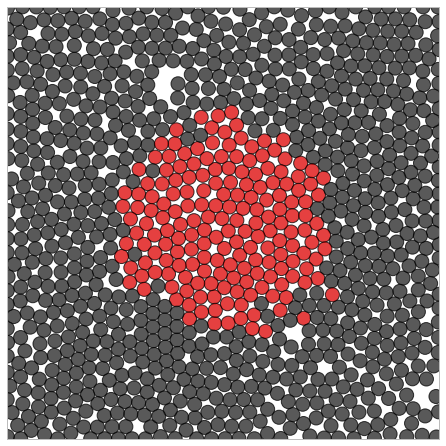

In [25]:
sim = moshpit.Moshpit(N=1024, phi=0.85)
sim.init_circle()
sim.relax()
plt = display.DisplayDiscs(sim)

In [26]:
%lprun -r -f forces.force5 forces.force5(sim)

In [45]:
def timer(func, args, reps=5):
    times = []

    for rep in xrange(reps):
        start = time.time()
        func(*args)
        end = time.time()
        times.append(end - start)

    return np.array(times).mean()

In [46]:
nlist = np.logspace(1, 4, 15).astype('int')
times = []

for n in nlist:
    sim = moshpit.Moshpit(N=n, phi=0.85)
    sim.relax()
    time4 = timer(forces.force4, args=(sim,))
    time5 = timer(forces.force5, args=(sim,))
    times.append((time4, time5))

times = np.array(times)

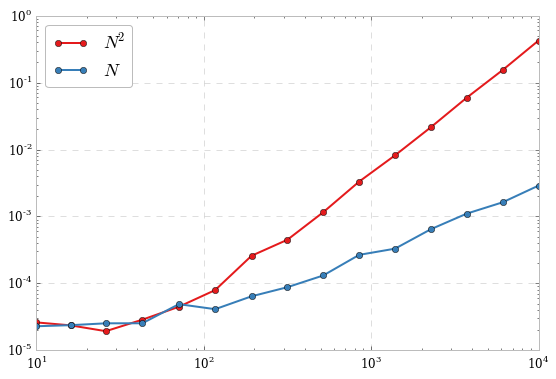

In [47]:
fig = pl.figure(figsize=(9,6))
pl.loglog(nlist, times[:,0], 'o-', label=r"$N^2$");
pl.loglog(nlist, times[:,1], 'o-', label=r"$N$");
pl.legend(loc='best', fontsize=18)